# Import


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from torchvision import transforms
import torch
import torch.nn as nn
import torchvision
from torch.utils.data import  DataLoader
import torch.optim as optim
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay


# config


In [ ]:
# GPU
device = ('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
# Transform (data augmentation) configuration values
IMAGE_SIZE = 227
resize_params=(IMAGE_SIZE, IMAGE_SIZE)
mean, std = [0.4914, 0.4822, 0.4465], [0.247, 0.243, 0.261]
random_rotation_params=20
random_flip_params=0.1
color_jitter_params={"brightness": 0.1, "contrast": 0.1, "saturation": 0.1}
random_sharpness_params={"sharpness_factor": 2, "p": 0.1}
normalize_params={"mean": mean, "std": std}
random_erasing_params={"p": 0.75, "scale": (0.02, 0.1), "value": 1.0}
transform_config = {'resize':True, 
                  'random_rotation':False, 
                  'random_flip':False, 
                  'color_jitter':False, 
                  'random_sharpness':False, 
                  'normalize':True, 
                  'random_erasing':False}
# hyper-parameters (for generalization, not for tuning)
random_seed = 42
# hyper-parameters (that should be tuned)
batch_size = 64

In [ ]:
# reset random for reproducibility
def reset_random(random_seed):
  torch.manual_seed(random_seed)
  torch.cuda.manual_seed(random_seed)
  torch.cuda.manual_seed_all(random_seed)  # if use multi-GPU
  torch.backends.cudnn.deterministic = True
  torch.backends.cudnn.benchmark = False
  np.random.seed(random_seed)
  random.seed(random_seed)

reset_random(random_seed)

## Transform Config


In [ ]:
# Function to dynamically create transforms
def build_transforms(
    resize=True,
    random_rotation=False,
    random_flip=False,
    color_jitter=False,
    random_sharpness=False,
    normalize=True,
    random_erasing=False,
):
    """
    Dynamically builds a transform pipeline based on user arguments.
    """
    transform_list = []

    if resize:
        transform_list.append(transforms.Resize(resize_params))  # Resize the image
    if random_rotation:
        transform_list.append(transforms.RandomRotation(random_rotation_params))  # Rotate the image
    if random_flip:
        transform_list.append(transforms.RandomHorizontalFlip(random_flip_params))  # Flip the image
    if color_jitter:
        transform_list.append(transforms.ColorJitter(**color_jitter_params))  # Adjust brightness, contrast, etc.
    if random_sharpness:
        transform_list.append(transforms.RandomAdjustSharpness(**random_sharpness_params))  # Adjust sharpness
    # ToTensor is essential
    transform_list.append(transforms.ToTensor())  # Convert to PyTorch tensor
    if normalize:
        transform_list.append(transforms.Normalize(**normalize_params))  # Normalize the image
    if random_erasing:
        transform_list.append(transforms.RandomErasing(**random_erasing_params))  # Erase random patches

    return transforms.Compose(transform_list)

# Load dataset


In [ ]:
def load_data(data_dir='./Cifar10', transform_config=None, non_transform_config = {'resize': True,
                                                                               'random_rotation': False,
                                                                                'random_flip': False,
                                                                                'color_jitter': False,
                                                                                'random_sharpness': False,
                                                                                'normalize': True,
                                                                                'random_erasing': False}):
    
    if transform_config is None:
        print("Note: Users didn't configure transform_config. Using default configuration.")
        
    transform = build_transforms(**transform_config)
    non_transform = build_transforms(**non_transform_config)
    
    train_val_dataset = torchvision.datasets.CIFAR10(
        root=data_dir, train=True, download=True, transform=None
    )
    test_dataset = torchvision.datasets.CIFAR10(
        root=data_dir, train=False, download=True, transform=non_transform
    )
    
    # split
    train_indices, val_indices = train_test_split(
        range(len(train_val_dataset)), test_size=0.2, random_state=random_seed
    )
    train_dataset = torch.utils.data.Subset(train_val_dataset, train_indices)
    val_dataset = torch.utils.data.Subset(train_val_dataset, val_indices)
    # apply transform
    train_dataset.dataset.transform = transform
    val_dataset.dataset.transform = non_transform

    return train_dataset, val_dataset, test_dataset

def get_dataloader(dataset, shuffle=True):
    return DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)

Files already downloaded and verified
Files already downloaded and verified


In [ ]:
train, dev, test = load_data(transform_config=transform_config)



In [ ]:
train_loader = get_dataloader(train)
dev_loader = get_dataloader(dev, shuffle=False)
test_loader = get_dataloader(test, shuffle=False)

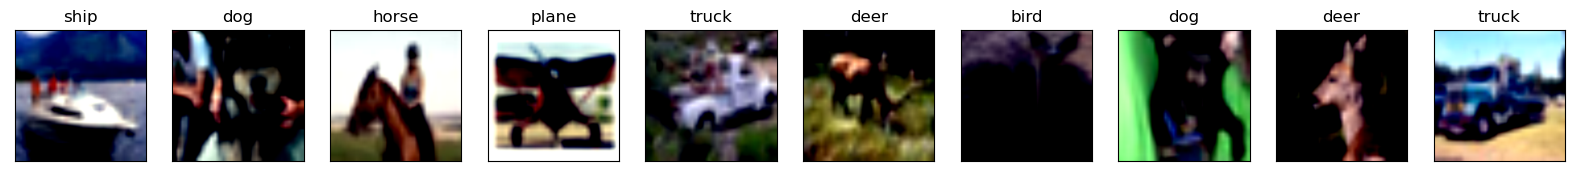

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
num_classes = len(classes)

# We need to convert the images to numpy arrays as tensors are not compatible with matplotlib.
def im_convert(tensor):
    img = tensor.cpu().clone().detach().numpy() #
    img = img.transpose(1, 2, 0)
    img = img * np.array(tuple(mean)) + np.array(tuple(std))
    img = img.clip(0, 1) # Clipping the size to print the images later
    return img

# Display an overview of data
def overview_data(loader, classes, num_images=5):
    data_iterable = iter(loader)  # Convert the loader to an iterable
    images, labels = next(data_iterable)  # Get the first batch

    num_images = min(num_images, len(images))  # Limit to the batch size
    fig = plt.figure(figsize=(20, 10))  # Create figure

    for idx in range(num_images):
        ax = fig.add_subplot(1, num_images, idx + 1, xticks=[], yticks=[])  # Add subplot
        plt.imshow(im_convert(images[idx]))  # Convert and display image
        ax.set_title(classes[labels[idx].item()])  # Set title

    plt.show()  # Display the figure

# Preview some data
overview_data(train_loader, classes, num_images=10)


# Models


In [17]:
class AlexNet(nn.Module):
  def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))

  def forward(self, x):
    out = self.layer1(x)
    out = self.layer2(out)
    out = self.layer3(out)
    out = self.layer4(out)
    out = self.layer5(out)
    out = out.reshape(out.size(0), -1)
    out = self.fc(out)
    out = self.fc1(out)
    out = self.fc2(out)
    return out

# Train


In [ ]:
def train_model(
    model, 
    train_loader, 
    dev_loader, 
    num_epochs=20, 
    learning_rate=0.005, 
    weight_decay=0.005, 
    momentum=0.9, 
    save_path="best_model.pth",
):
    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(model.parameters(), lr=learning_rate, weight_decay=weight_decay, momentum=momentum)

    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []
    best_val_acc = 0.0  # Best validation accuracy for saving model

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        
        # Training phase
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        train_bar = tqdm(train_loader, desc="Training", leave=False)

        for images, labels in train_bar:
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            
            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            # Metrics calculation
            running_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            # Collect predictions and labels
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            # Update tqdm description
            train_bar.set_postfix(loss=loss.item())

        # Calculate epoch metrics
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100 * correct / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        print(f"Train Loss: {epoch_loss:.4f}, Train Accuracy: {epoch_acc:.2f}%")

        # Training confusion matrix and report
        cm_train = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))
        print("\nTraining Confusion Matrix:")
        print(cm_train)

        if classes:
            print("\nTraining Classification Report:")
            print(classification_report(all_labels, all_preds, target_names=classes))

        # Validation phase
        model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        all_preds = []
        all_labels = []
        val_bar = tqdm(dev_loader, desc="Validating", leave=False)

        with torch.no_grad():
            for images, labels in val_bar:
                images, labels = images.to(device), labels.to(device)
                
                # Forward pass
                outputs = model(images)
                loss = criterion(outputs, labels)

                # Metrics calculation
                running_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

                # Collect predictions and labels
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

                # Update tqdm description
                val_bar.set_postfix(loss=loss.item())

        # Calculate epoch metrics
        epoch_loss = running_loss / len(dev_loader)
        epoch_acc = 100 * correct / total
        val_loss.append(epoch_loss)
        val_acc.append(epoch_acc)

        print(f"Val Loss: {epoch_loss:.4f}, Val Accuracy: {epoch_acc:.2f}%")

        # Validation confusion matrix and report
        cm_val = confusion_matrix(all_labels, all_preds, labels=np.arange(num_classes))
        print("\nValidation Confusion Matrix:")
        print(cm_val)

        if classes:
            print("\nValidation Classification Report:")
            print(classification_report(all_labels, all_preds, target_names=classes))

        # Save the best model
        if epoch_acc > best_val_acc:
            best_val_acc = epoch_acc
            torch.save(model.state_dict(), save_path)
            print(f"Model saved to {save_path} with Val Accuracy: {epoch_acc:.2f}%")

    print(f"\nTraining complete. Best Validation Accuracy: {best_val_acc:.2f}%")
    return train_loss, val_loss, train_acc, val_acc


In [19]:
model = AlexNet(num_classes=num_classes)

# Train and validate
train_loss, val_loss, train_acc, val_acc = train_model(
    model=model,
    train_loader=train_loader,
    dev_loader=dev_loader,
    num_epochs=20,
    learning_rate=0.005,
    weight_decay=0.005,
    momentum=0.9,
    save_path="best_model.pth"
)


Epoch 1/20


KeyboardInterrupt: 

# Testing


In [ ]:

def evaluate_best_model(
    model, 
    test_loader, 
    load_path="best_model.pth",
):
    """
    Evaluate the best saved model on test data and display results.
    """
    # Load the best model weights
    model.load_state_dict(torch.load(load_path))
    model = model.to(device)
    model.eval()

    correct = 0
    total = 0
    all_labels = []
    all_predictions = []

    print("\nEvaluating the best model on test data...")
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc="Testing", leave=False):
            images, labels = images.to(device), labels.to(device)
            
            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Metrics calculation
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Collect predictions and labels for confusion matrix
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

            # GPU memory management
            del images, labels, outputs

    # Calculate accuracy
    accuracy = 100 * correct / total
    print(f"\nTest Accuracy: {accuracy:.2f}%")

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_predictions, labels=np.arange(num_classes))
    print("\nConfusion Matrix:")
    print(cm)

    # Classification Report
    if classes:
        print("\nClassification Report:")
        print(classification_report(all_labels, all_predictions, target_names=classes))

    # Display Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes if classes else np.arange(num_classes))
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix: Test Data")
    plt.show()

    return accuracy, cm


In [ ]:
test_accuracy, test_cm = evaluate_best_model(
    model=model, 
    test_loader=test_loader, 
    num_classes=num_classes, 
    load_path="best_model.pth",
    classes=classes  
)

In [ ]:


# def train_model(train_loader, dev_loader, num_epochs=20, learning_rate=0.005, weight_decay = 0.005, momentum = 0.9):
#     model = AlexNet(num_classes).to(device)
#     criterion = nn.CrossEntropyLoss()
#     optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = weight_decay, momentum = momentum)
#     total_step = len(train_loader)
#     train_loss = []
#     val_loss = []
#     for epoch in range(num_epochs):
#         model.train()
#         running_loss = 0.0
#         for i, (images, labels) in enumerate(train_loader):
#             images = images.to(device)
#             labels = labels.to(device)
#             optimizer.zero_grad()
#             outputs = model(images)
#             loss = criterion(outputs, labels)
#             loss.backward()
#             optimizer.step()
#             running_loss += loss.item()
#         train_loss.append(running_loss / total_step)
#         print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")
        
#         # Validation
#         model.eval()
#         running_loss = 0.0
#         with torch.no_grad():
#             for i, (images, labels) in enumerate(dev_loader):
#                 images = images.to(device)
#                 labels = labels.to(device)
#                 outputs = model(images)
#                 loss = criterion(outputs, labels)
#                 running_loss += loss.item()
#         val_loss.append(running_loss / len(dev_loader))
        
#     return train_loss, val_loss

In [ ]:
# train_model(train_loader, dev_loader, 
#             num_epochs, 
#             learning_rate, 
#             weight_decay, 
#             momentum)

# Train


In [16]:
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}'
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))

    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in test_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs

        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

Epoch [1/20], Step [704/704], Loss: 1.0719
Accuracy of the network on the 5000 validation images: 59.81 %
Epoch [2/20], Step [704/704], Loss: 1.3118
Accuracy of the network on the 5000 validation images: 68.11 %
Epoch [3/20], Step [704/704], Loss: 1.4713
Accuracy of the network on the 5000 validation images: 69.65 %
Epoch [4/20], Step [704/704], Loss: 1.2918
Accuracy of the network on the 5000 validation images: 75.19 %
Epoch [5/20], Step [704/704], Loss: 0.9219
Accuracy of the network on the 5000 validation images: 77.47 %
Epoch [6/20], Step [704/704], Loss: 0.6828
Accuracy of the network on the 5000 validation images: 77.84 %
Epoch [7/20], Step [704/704], Loss: 0.3045
Accuracy of the network on the 5000 validation images: 78.54 %
Epoch [8/20], Step [704/704], Loss: 1.0087
Accuracy of the network on the 5000 validation images: 78.63 %
Epoch [9/20], Step [704/704], Loss: 0.5275
Accuracy of the network on the 5000 validation images: 80.39 %
Epoch [10/20], Step [704/704], Loss: 0.3058
Ac

In [17]:
PATH = 'Models/'

In [18]:
torch.save(model.state_dict(), f="AlexNet_Baseline.pt")

Accuracy of the network on the 10000 test images: 82.39 %


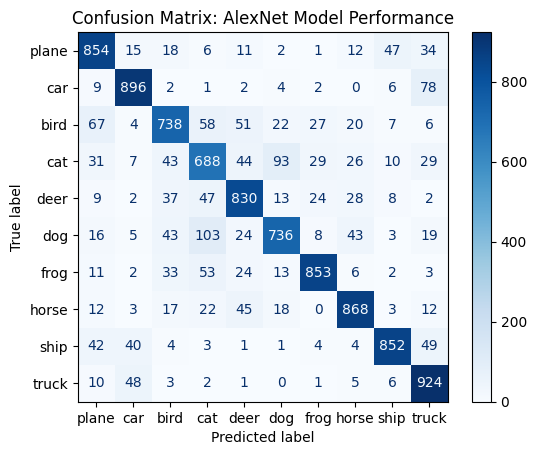

In [25]:
with torch.no_grad():
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))

    cm = confusion_matrix(all_labels, all_predictions)

    # Display confusion matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=classes)
    disp.plot(cmap=plt.cm.Blues)
    plt.title("Confusion Matrix: AlexNet Model Performance")
    plt.show()



# Confusion Matrix
